In [1]:
%matplotlib inline
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg import HeisenbergModel, get_n_steps, get_prob0
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
from datetime import datetime, timezone

In [3]:
current_time = (
    datetime.now(timezone.utc).isoformat(timespec="milliseconds").replace("+00:00", "Z")
)
print(current_time)

2024-11-14T12:57:37.266Z


In [4]:
os.makedirs(f"./data/{current_time}", exist_ok=True)

In [5]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, operational=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['x', 'cz', 'sx', 'measure', 'id', 'reset', 'xslow']>)


# データセット作成 $\exp(-\beta H)$

In [6]:
n_samples = 100
n_qubits = 8
beta = 1

In [7]:
# State |111000> (half 1 and half 0 state) (can be adjusted for other sizes)
state = np.zeros(2**n_qubits, dtype=complex)
index = int("1" * (n_qubits // 2) + "0" * (n_qubits // 2), 2)
state[index] = 1

In [8]:
rng = np.random.default_rng(42)
data = []
eigvals = []
for i in range(n_samples):
    Js = rng.uniform(-1, 1, n_qubits - 1)
    heisenberg = HeisenbergModel(n_qubits, Js)
    H = heisenberg.get_hamiltonian()

    eigvals.append(np.linalg.eigvalsh(H))

    fH = scipy.linalg.expm(-beta * H)

    # Compute the expectation value <111000|exp(-beta*H)|111000>
    y = np.vdot(state, fH @ state).real
    data.append({"Js": Js, "expected_value": y})

df = pd.DataFrame(data)
df

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",4.172305
1,"[0.5721286105539076, -0.7437727346489083, -0.0...",0.567842
2,"[-0.11317160234533774, -0.5455225564304462, 0....",1.871539
3,"[-0.2909480637402633, 0.9413960487898065, 0.78...",0.639599
4,"[-0.6914210158649043, 0.36609790648490925, 0.4...",0.512634
...,...,...
95,"[0.4352782952831351, 0.6148632119525634, 0.997...",1.664801
96,"[0.9951600745258344, 0.401762020241317, 0.1904...",0.228219
97,"[-0.26924307360173305, -0.8656666623044662, -0...",31.453439
98,"[-0.15923645698944577, 0.9184185456891518, 0.5...",13.532093


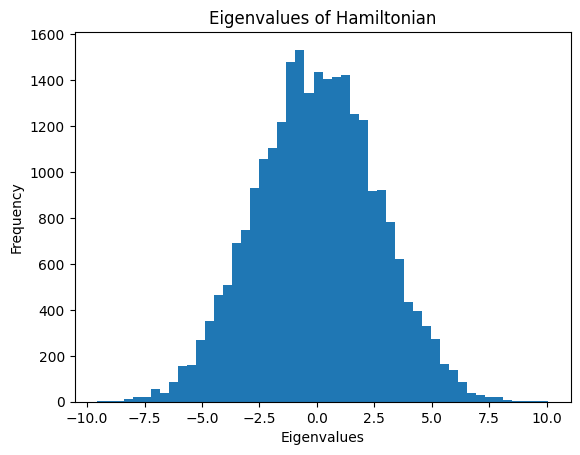

In [9]:
# Plot histogram of eigenvalues
eigvals = np.array(eigvals).flatten()
plt.hist(eigvals, bins=50)
plt.xlabel("Eigenvalues")
plt.ylabel("Frequency")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

In [10]:
# Parameters for the Fourier feature generation
C = 10 * n_qubits  # upper bound for eigenvalues
n_features = 5  # Number of Fourier features

times = [k * np.pi / C for k in range(n_features)]
print(times)

[0.0, 0.039269908169872414, 0.07853981633974483, 0.11780972450961724, 0.15707963267948966]


In [11]:
# Save parameters
with open(f"./data/{current_time}/params.pkl", "wb") as f:
    pickle.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

In [12]:
# Load parameters
# current_time = "2024-11-14T05:27:22.407Z"
with open(f"./data/{current_time}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
all_expected_values = params["expected_values"]

## Fourier feature の生成 (Exact simulation)

In [ ]:
# Exact simulation
data = []
probs_phase0_exact = []
probs_phase1_exact = []
probs_phase2_exact = []
probs_phase3_exact = []

# Generate the dataset with Fourier features
# for index, row in df.iterrows():
for i in range(n_samples):
    print(f"Calculating features for sample {i}")
    Js = all_Js[i]
    lambda_ref = np.sum(Js)  # Reference eigenvalue.
    features = []

    # Compute the Fourier features for different times
    for t in times:
        heisenberg = HeisenbergModel(n_qubits, Js)
        prob_phase0 = heisenberg.exact_simulation(t, phase=0)
        prob_phase1 = heisenberg.exact_simulation(t, phase=1)
        prob_phase2 = heisenberg.exact_simulation(t, phase=2)
        prob_phase3 = heisenberg.exact_simulation(t, phase=3)
        probs_phase0_exact.append(prob_phase0)
        probs_phase1_exact.append(prob_phase1)
        probs_phase2_exact.append(prob_phase2)
        probs_phase3_exact.append(prob_phase3)

        inner_product = np.exp(-1j * lambda_ref * t) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if t != times[0]:
            features.append(inner_product.imag)
    data.append([*features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_exact_df = pd.DataFrame(data, columns=columns)
display(data_exact_df)

# Save the exact data
with open(f"./data/{current_time}/data_exact_df.pkl", "wb") as f:
    pickle.dump(data_exact_df, f)

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,1.0,0.997143,-0.011673,0.988601,-0.023410,0.974452,-0.035272,0.954831,-0.047316,4.172305
1,1.0,0.999386,-0.026768,0.997551,-0.053443,0.994509,-0.079931,0.990288,-0.106144,0.567842
2,1.0,0.999583,0.020173,0.998331,0.040326,0.996248,0.060441,0.993338,0.080497,1.871539
3,1.0,0.999764,-0.021083,0.999057,-0.042158,0.997879,-0.063219,0.996233,-0.084256,0.639599
4,1.0,0.999099,-0.037258,0.996397,-0.074446,0.991900,-0.111493,0.985620,-0.148330,0.512634
...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.994186,-0.091382,0.976829,-0.181519,0.948188,-0.269179,0.908688,-0.353167,1.664801
96,1.0,0.998317,-0.057992,0.993273,-0.115789,0.984886,-0.173196,0.973184,-0.230020,0.228219
97,1.0,0.991026,0.131993,0.964271,0.261550,0.920234,0.386283,0.859738,0.503891,31.453439
98,1.0,0.997931,0.015992,0.991787,0.031364,0.981749,0.045518,0.968114,0.057903,13.532093


## Fourier feature の生成 (Trotter, Noise free Simulator)

In [17]:
# Create circuits
# 1 jobs - 1 sample
all_isa_circuits = []
lambda_refs = []

# for index, row in df.iterrows():
for i in range(n_samples):
    print(f"Creating circuits for sample {i}")
    Js = all_Js[i]
    lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    heisenberg_sim = HeisenbergModel(n_qubits, Js, backend=backend_sim)

    circuits_per_sample = []
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, isa_circuit_phase0 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=0
        )
        circuit_phase1, isa_circuit_phase1 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=1
        )
        circuit_phase2, isa_circuit_phase2 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=2
        )
        circuit_phase3, isa_circuit_phase3 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=3
        )
        circuits_per_sample += [
            isa_circuit_phase0,
            isa_circuit_phase1,
            isa_circuit_phase2,
            isa_circuit_phase3,
        ]
    all_isa_circuits.append(circuits_per_sample)

Creating circuits for sample 0
Creating circuits for sample 1
Creating circuits for sample 2
Creating circuits for sample 3
Creating circuits for sample 4
Creating circuits for sample 5
Creating circuits for sample 6
Creating circuits for sample 7
Creating circuits for sample 8
Creating circuits for sample 9
Creating circuits for sample 10
Creating circuits for sample 11
Creating circuits for sample 12
Creating circuits for sample 13
Creating circuits for sample 14
Creating circuits for sample 15
Creating circuits for sample 16
Creating circuits for sample 17
Creating circuits for sample 18
Creating circuits for sample 19
Creating circuits for sample 20
Creating circuits for sample 21
Creating circuits for sample 22
Creating circuits for sample 23
Creating circuits for sample 24
Creating circuits for sample 25
Creating circuits for sample 26
Creating circuits for sample 27
Creating circuits for sample 28
Creating circuits for sample 29
Creating circuits for sample 30
Creating circuits 

In [18]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim):
    sampler = Sampler()
    for i, circuits_per_sample in enumerate(all_isa_circuits):
        sampler.options.environment.job_tags = [f"{i}"]
        job = sampler.run(circuits_per_sample)
        jobs.append(job)

In [19]:
check_list = []
for i in range(n_samples):
    job = jobs[i]
    job_id = job.job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,e5329fad-da57-41d8-a119-becab784af03,0,DONE
1,08fe0e2a-8f69-4136-9e87-409d36d67702,1,DONE
2,e342ace1-92df-49af-91ab-50a393f35a9d,2,DONE
3,70d76895-99ef-4ea8-907e-cc81f695bb73,3,DONE
4,9229ef49-ad56-40a2-805a-6d8be4af030a,4,DONE
...,...,...,...
95,aec1a5d6-eb14-4f91-8943-fc1e90441c1d,95,DONE
96,5abdf136-5b92-4461-9f02-9aff9e7ce540,96,DONE
97,d160e8b7-9a34-4375-b004-da49a7d611ba,97,DONE
98,64557b90-f5e7-4744-ad96-c2b21d8800d6,98,DONE


In [20]:
# Post-process
data_sim = []
probs_phase0_sim = []
probs_phase1_sim = []
probs_phase2_sim = []
probs_phase3_sim = []

for i in range(n_samples):
    features = []
    for k in range(n_features):
        # Get results of each phase in a batch
        phase_results = job.result()[4 * k : 4 * k + 4]
        probs = [get_prob0(phase_result, n_qubits) for phase_result in phase_results]

        prob_phase0 = probs[0]
        prob_phase1 = probs[1]
        prob_phase2 = probs[2]
        prob_phase3 = probs[3]

        probs_phase0_sim.append(prob_phase0)
        probs_phase1_sim.append(prob_phase1)
        probs_phase2_sim.append(prob_phase2)
        probs_phase3_sim.append(prob_phase3)

        inner_product = np.exp(-1j * lambda_refs[i] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim.append([*features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_df = pd.DataFrame(data_sim, columns=columns)
display(data_sim_df)

# Save the simulation data
with open(f"./data/{current_time}/data_sim_df.pkl", "wb") as f:
    pickle.dump(data_sim_df, f)

 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No co

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,1.0,0.996226,-0.075480,0.990333,-0.119268,0.977967,-0.190539,0.962146,-0.250819,4.172305
1,1.0,0.998336,-0.038585,0.996439,-0.045741,0.993053,-0.081062,0.988610,-0.106234,0.567842
2,1.0,0.999029,0.010237,0.996147,0.051727,0.994240,0.064898,0.990414,0.087841,1.871539
3,1.0,0.999068,-0.005100,0.997265,0.021124,0.996174,0.019058,0.993938,0.026898,0.639599
4,1.0,0.999062,-0.006164,0.997308,0.019000,0.996230,0.015875,0.994043,0.022664,0.512634
...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.998798,-0.023766,0.997358,-0.016152,0.995677,-0.036787,0.993171,-0.047399,1.664801
96,1.0,0.997988,-0.046728,0.995560,-0.061993,0.990772,-0.105339,0.984618,-0.138432,0.228219
97,1.0,0.991653,0.121605,0.959893,0.271274,0.917511,0.388457,0.855088,0.507406,31.453439
98,1.0,0.998451,-0.035471,0.996705,-0.039525,0.993768,-0.071767,0.989859,-0.093893,13.532093


## Fourier feature の生成 (Trotter, Noisy Simulator)

In [21]:
# Create circuits
# 1 jobs - 1 sample
all_isa_circuits = []
lambda_refs = []

for i in range(n_samples):
    print(f"Creating circuits for sample {i}")
    Js = all_Js[i]
    lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    heisenberg_sim_noisy = HeisenbergModel(n_qubits, Js, backend=backend_sim_noisy)

    circuits_per_sample = []
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, isa_circuit_phase0 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=0
        )
        circuit_phase1, isa_circuit_phase1 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=1
        )
        circuit_phase2, isa_circuit_phase2 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=2
        )
        circuit_phase3, isa_circuit_phase3 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=3
        )
        circuits_per_sample += [
            isa_circuit_phase0,
            isa_circuit_phase1,
            isa_circuit_phase2,
            isa_circuit_phase3,
        ]
    all_isa_circuits.append(circuits_per_sample)

Creating circuits for sample 0
Creating circuits for sample 1
Creating circuits for sample 2
Creating circuits for sample 3
Creating circuits for sample 4
Creating circuits for sample 5
Creating circuits for sample 6
Creating circuits for sample 7
Creating circuits for sample 8
Creating circuits for sample 9
Creating circuits for sample 10
Creating circuits for sample 11
Creating circuits for sample 12
Creating circuits for sample 13
Creating circuits for sample 14
Creating circuits for sample 15
Creating circuits for sample 16
Creating circuits for sample 17
Creating circuits for sample 18
Creating circuits for sample 19
Creating circuits for sample 20
Creating circuits for sample 21
Creating circuits for sample 22
Creating circuits for sample 23
Creating circuits for sample 24
Creating circuits for sample 25
Creating circuits for sample 26
Creating circuits for sample 27
Creating circuits for sample 28
Creating circuits for sample 29
Creating circuits for sample 30
Creating circuits 

In [22]:
# Run jobs in batch
job_ids = []
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()
    for i, circuits_per_sample in enumerate(all_isa_circuits):
        print(f"Running job {i}")
        sampler.options.environment.job_tags = [f"{i}"]
        job = sampler.run(circuits_per_sample)
        job_ids.append(job.job_id())

Running job 0
Running job 1
Running job 2
Running job 3
Running job 4
Running job 5
Running job 6
Running job 7
Running job 8
Running job 9
Running job 10
Running job 11
Running job 12
Running job 13
Running job 14
Running job 15
Running job 16
Running job 17
Running job 18
Running job 19
Running job 20
Running job 21
Running job 22
Running job 23
Running job 24
Running job 25
Running job 26
Running job 27
Running job 28
Running job 29
Running job 30
Running job 31
Running job 32
Running job 33
Running job 34
Running job 35
Running job 36
Running job 37
Running job 38
Running job 39
Running job 40
Running job 41
Running job 42
Running job 43
Running job 44
Running job 45
Running job 46
Running job 47
Running job 48
Running job 49
Running job 50
Running job 51
Running job 52
Running job 53
Running job 54
Running job 55
Running job 56
Running job 57
Running job 58
Running job 59
Running job 60
Running job 61
Running job 62
Running job 63
Running job 64
Running job 65
Running job 66
Runni

In [23]:
check_list = []
for i in range(n_samples):
    job_id = job_ids[i]
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,9f9bbd19-8e48-4ba4-8661-05d61586560b,0,DONE
1,f846b7b1-10d6-443c-9023-87af4140edc7,1,DONE
2,6a0b99e2-ae38-4b21-9842-e8bd685f0b04,2,DONE
3,dd587ea1-bf21-48e1-b466-bdc7e4422dc8,3,DONE
4,51712d61-9614-4d7f-8ae9-358af2c2089e,4,DONE
...,...,...,...
95,bdac23e4-6232-4a08-8ca5-cd6bb09cdbda,95,DONE
96,8ff2d645-b464-488b-acf0-f211ed17a154,96,DONE
97,d438595b-4e77-4f1c-a752-8fc433c0e066,97,DONE
98,6c417482-4e97-4fcf-9596-c35139ca6b96,98,DONE


In [24]:
# Post-process
data_sim_noisy = []
probs_phase0_sim_noisy = []
probs_phase1_sim_noisy = []
probs_phase2_sim_noisy = []
probs_phase3_sim_noisy = []

for i in range(n_samples):
    features = []
    for k in range(n_features):
        # Get results of each phase in a batch
        phase_results = job.result()[4 * k : 4 * k + 4]
        probs = [get_prob0(phase_result, n_qubits) for phase_result in phase_results]

        prob_phase0 = probs[0]
        prob_phase1 = probs[1]
        prob_phase2 = probs[2]
        prob_phase3 = probs[3]

        probs_phase0_sim_noisy.append(prob_phase0)
        probs_phase1_sim_noisy.append(prob_phase1)
        probs_phase2_sim_noisy.append(prob_phase2)
        probs_phase3_sim_noisy.append(prob_phase3)

        inner_product = np.exp(-1j * lambda_refs[i] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim_noisy.append([*features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_noisy_df = pd.DataFrame(data_sim_noisy, columns=columns)
display(data_sim_noisy_df)

# Save the simulation data
with open(f"./data/{current_time}/data_sim_noisy_df.pkl", "wb") as f:
    pickle.dump(data_sim_noisy_df, f)

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0.865234,0.897308,-0.017904,0.874341,-0.107951,0.855934,-0.193551,0.860997,-0.191579,4.172305
1,0.865234,0.897357,0.015294,0.879928,-0.043029,0.872104,-0.097569,0.879833,-0.062553,0.567842
2,0.865234,0.895538,0.059117,0.879927,0.043055,0.877001,0.030896,0.875223,0.109558,1.871539
3,0.865234,0.896340,0.045364,0.880834,0.016024,0.877494,-0.009511,0.880297,0.055643,0.639599
4,0.865234,0.896388,0.044409,0.880866,0.014148,0.877459,-0.012314,0.880526,0.051893,0.512634
...,...,...,...,...,...,...,...,...,...,...
95,0.865234,0.897031,0.028608,0.880817,-0.016898,0.875582,-0.058661,0.881994,-0.010248,1.664801
96,0.865234,0.897452,0.007972,0.879109,-0.057379,0.869455,-0.118882,0.877324,-0.091225,0.228219
97,0.865234,0.883356,0.158637,0.848487,0.237053,0.817990,0.317770,0.741830,0.477187,31.453439
98,0.865234,0.897305,0.018092,0.880179,-0.037540,0.872979,-0.089406,0.880545,-0.051572,13.532093


## Fourier feature の生成 (Trotter 近似, QPU)

In [25]:
# For the case session is expired, you can reinitialize the service with the following line.
backend_qpu = service.backend(backend_qpu.name)

In [26]:
# Create circuits
# 1 jobs - 1 sample
all_isa_circuits = []
lambda_refs = []

for i in range(n_samples):
    print(f"Creating circuits for sample {i}")
    Js = all_Js[i]
    lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    heisenberg_qpu = HeisenbergModel(n_qubits, Js, backend=backend_qpu)

    circuits_per_sample = []
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, isa_circuit_phase0 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=0
        )
        circuit_phase1, isa_circuit_phase1 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=1
        )
        circuit_phase2, isa_circuit_phase2 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=2
        )
        circuit_phase3, isa_circuit_phase3 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=3
        )
        circuits_per_sample += [
            isa_circuit_phase0,
            isa_circuit_phase1,
            isa_circuit_phase2,
            isa_circuit_phase3,
        ]
    all_isa_circuits.append(circuits_per_sample)

Creating circuits for sample 0
Creating circuits for sample 1
Creating circuits for sample 2
Creating circuits for sample 3
Creating circuits for sample 4
Creating circuits for sample 5
Creating circuits for sample 6
Creating circuits for sample 7
Creating circuits for sample 8
Creating circuits for sample 9
Creating circuits for sample 10
Creating circuits for sample 11
Creating circuits for sample 12
Creating circuits for sample 13
Creating circuits for sample 14
Creating circuits for sample 15
Creating circuits for sample 16
Creating circuits for sample 17
Creating circuits for sample 18
Creating circuits for sample 19
Creating circuits for sample 20
Creating circuits for sample 21
Creating circuits for sample 22
Creating circuits for sample 23
Creating circuits for sample 24
Creating circuits for sample 25
Creating circuits for sample 26
Creating circuits for sample 27
Creating circuits for sample 28
Creating circuits for sample 29
Creating circuits for sample 30
Creating circuits 

In [ ]:
# Run jobs in batch
job_ids = []
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True
    for i, circuits_per_sample in enumerate(all_isa_circuits):
        print(f"Running job for sample {i}")
        sampler.options.environment.job_tags = [f"{i}"]
        job = sampler.run(circuits_per_sample)
        job_ids.append(job.job_id())

job ID: cwtzrg2997wg008xsw80
job ID: cwtzrgj5v39g008hjhmg
job ID: cwtzrh22ac5g008j8xfg
job ID: cwtzrhjehebg008jb0z0
job ID: cwtzrj260bqg008pk7dg
job ID: cwtzrjaehebg008jb0zg
job ID: cwtzrjttdtng008784sg
job ID: cwtzrka997wg008xswa0
job ID: cwtzrkj5v39g008hjhn0
job ID: cwtzrm2tdtng008784t0
job ID: cwtzrmatdtng008784tg
job ID: cwtzrmt5v39g008hjhng
job ID: cwtzrna60bqg008pk7e0
job ID: cwtzrnttdtng008784v0
job ID: cwtzrp260bqg008pk7eg
job ID: cwtzrpjehebg008jb100
job ID: cwtzrq25v39g008hjhp0
job ID: cwtzrqa997wg008xswag
job ID: cwtzrqtehebg008jb10g
job ID: cwtzrrb997wg008xswb0
job ID: cwtzrrvtdtng008784w0
job ID: cwtzrs3tdtng008784wg
job ID: cwtzrsk60bqg008pk7f0
job ID: cwtzrt360bqg008pk7fg
job ID: cwtzrtb5v39g008hjhq0
job ID: cwtzrtv997wg008xswbg
job ID: cwtzrvbehebg008jb120
job ID: cwtzrvk60bqg008pk7gg
job ID: cwtzrw3tdtng008784x0
job ID: cwtzrwk60bqg008pk7h0
job ID: cwtzrx3997wg008xswcg
job ID: cwtzrxb5v39g008hjhqg
job ID: cwtzrxv997wg008xswd0
job ID: cwtzryb997wg008xswdg
job ID: cwtzry

In [28]:
with open(f"./data/{current_time}/first_try_job_ids.txt", "w") as f:
    for job_id in job_ids:
        f.write(f"{job_id}\n")

first_try_started_at = batch.details()["started_at"]
mit.cals_to_file(
    f"./data/{current_time}/calibrations_{backend_qpu.name}_{first_try_started_at}.json",
)
with open(f"./data/{current_time}/first_try_started_at.txt", "w") as f:
    f.write(first_try_started_at)

## Below should be run after first running

In [30]:
# Load the params, job IDs and started_at time
# current_time = "2024-11-14T05:27:22.407Z"
with open(f"./data/{current_time}/params.pkl", "rb") as f:
    params = pickle.load(f)
backend_qpu_name = params["backend_qpu_name"]

with open(f"./data/{current_time}/first_try_job_ids.txt", "r") as f:
    first_try_job_ids = [job_id.strip() for job_id in f.readlines()]
with open(f"./data/{current_time}/first_try_started_at.txt", "r") as f:
    first_try_started_at = f.read()

# Load calibration data
cals_file = (
    f"./data/{current_time}/calibrations_{backend_qpu_name}_{first_try_started_at}.json"
)
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

In [31]:
# Scan the status of the jobs
first_try_jobs_check_list = []
successful_job_ids = []
successful_samples = []
failed_job_ids = []
failed_samples = []

for i in range(n_samples):
    print(f"Checking job {i}")
    job_id = first_try_job_ids[i]
    job = service.job(job_id)
    sample_id = job.tags[0]
    first_try_jobs_check_list.append(
        {
            "Job ID": job_id,
            "sample_id": sample_id,
            "Status": job.status(),
        }
    )
    if job.status() == "DONE":
        successful_job_ids.append(job_id)
        successful_samples.append(sample_id)
    elif job.status() == "ERROR":
        failed_job_ids.append(job_id)
        failed_samples.append(sample_id)

first_try_jobs_df = pd.DataFrame(first_try_jobs_check_list)
display(first_try_jobs_df)

print(f"Successful job IDs: {successful_job_ids}")
print(f"Successful samples: {successful_samples}")
print(f"Success rate: {len(successful_job_ids) / n_samples}")
with open(f"./data/{current_time}/successful_job_ids.txt", "w") as f:
    for job_id in successful_job_ids:
        f.write(f"{job_id}\n")

print(f"Failed job IDs: {failed_job_ids}")
print(f"Failed samples: {failed_samples}")
print(f"Failed rate: {len(failed_job_ids) / n_samples}")
with open(f"./data/{current_time}/failed_job_ids.txt", "w") as f:
    for job_id in failed_job_ids:
        f.write(f"{job_id}\n")

Checking job 0
Checking job 1
Checking job 2
Checking job 3
Checking job 4
Checking job 5
Checking job 6
Checking job 7
Checking job 8
Checking job 9
Checking job 10
Checking job 11
Checking job 12
Checking job 13
Checking job 14
Checking job 15
Checking job 16
Checking job 17
Checking job 18
Checking job 19
Checking job 20
Checking job 21
Checking job 22
Checking job 23
Checking job 24
Checking job 25
Checking job 26
Checking job 27
Checking job 28
Checking job 29
Checking job 30
Checking job 31
Checking job 32
Checking job 33
Checking job 34
Checking job 35
Checking job 36
Checking job 37
Checking job 38
Checking job 39
Checking job 40
Checking job 41
Checking job 42
Checking job 43
Checking job 44
Checking job 45
Checking job 46
Checking job 47
Checking job 48
Checking job 49
Checking job 50
Checking job 51
Checking job 52
Checking job 53
Checking job 54
Checking job 55
Checking job 56
Checking job 57
Checking job 58
Checking job 59
Checking job 60
Checking job 61
Checking job 62
Ch

,Job ID,sample_id,Status
0,cwtzrg2997wg008xsw80,0,DONE
1,cwtzrgj5v39g008hjhmg,1,DONE
2,cwtzrh22ac5g008j8xfg,2,DONE
3,cwtzrhjehebg008jb0z0,3,DONE
4,cwtzrj260bqg008pk7dg,4,DONE
...,...,...,...
95,cwtzsqptdtng0087853g,95,DONE
96,cwtzsr72ac5g008j8xp0,96,DONE
97,cwtzsrqtdtng00878540,97,DONE
98,cwtzsrztdtng0087854g,98,DONE


Successful job IDs: ['cwtzrg2997wg008xsw80', 'cwtzrgj5v39g008hjhmg', 'cwtzrh22ac5g008j8xfg', 'cwtzrhjehebg008jb0z0', 'cwtzrj260bqg008pk7dg', 'cwtzrjaehebg008jb0zg', 'cwtzrjttdtng008784sg', 'cwtzrka997wg008xswa0', 'cwtzrkj5v39g008hjhn0', 'cwtzrm2tdtng008784t0', 'cwtzrmatdtng008784tg', 'cwtzrmt5v39g008hjhng', 'cwtzrna60bqg008pk7e0', 'cwtzrnttdtng008784v0', 'cwtzrp260bqg008pk7eg', 'cwtzrpjehebg008jb100', 'cwtzrq25v39g008hjhp0', 'cwtzrqa997wg008xswag', 'cwtzrqtehebg008jb10g', 'cwtzrrb997wg008xswb0', 'cwtzrrvtdtng008784w0', 'cwtzrs3tdtng008784wg', 'cwtzrsk60bqg008pk7f0', 'cwtzrt360bqg008pk7fg', 'cwtzrtb5v39g008hjhq0', 'cwtzrtv997wg008xswbg', 'cwtzrvbehebg008jb120', 'cwtzrvk60bqg008pk7gg', 'cwtzrw3tdtng008784x0', 'cwtzrwk60bqg008pk7h0', 'cwtzrx3997wg008xswcg', 'cwtzrxb5v39g008hjhqg', 'cwtzrxv997wg008xswd0', 'cwtzryb997wg008xswdg', 'cwtzrykehebg008jb12g', 'cwtzrz360bqg008pk7hg', 'cwtzrzbehebg008jb130', 'cwtzrzv997wg008xswe0', 'cwtzs0460bqg008pk7j0', 'cwtzs0m5v39g008hjhrg', 'cwtzs1460bqg008pk7

### Retry failed jobs (To Do: fix)

In [ ]:
# To Do: fix the code below
# Fetch failed circuits
failed_circuits = []

for failed_sample in failed_samples:
    failed_circuits.append(all_circuits[int(failed_sample)])

In [ ]:
# Retry jobs in batch
retried_jobs = []
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    # Turn on dynamical decoupling.
    mit.cals_from_system(runtime_mode=batch)
    sampler.options.dynamical_decoupling.enable = True
    for i, failed_sample in enumerate(failed_samples):
        sampler.options.environment.job_tags = [f"{failed_samples[i]}", "retry"]
        retried_job = sampler.run(failed_circuits[i])
        retried_jobs.append(retried_job)

In [ ]:
# Save retried job IDs to a file
os.makedirs("./retried_cals", exist_ok=True)
os.makedirs("./retried_job_ids", exist_ok=True)
os.makedirs("./retried_started_at", exist_ok=True)

retried_started_at = batch.details()["started_at"]
mit.cals_to_file(f"./retried_cals/{backend_qpu.name}_{retried_started_at}.json")
with open(f"./retried_job_ids/{backend_qpu.name}_{retried_started_at}.txt", "w") as f:
    for job in retried_jobs:
        f.write(f"{job.job_id()}\n")

# Save retried started_at time to a file
with open(
    f"./retried_started_at/{backend_qpu.name}_{retried_started_at}.txt", "w"
) as f:
    f.write(retried_started_at)

In [ ]:
retried_check_list = []
for i in range(len(retried_jobs)):
    print(f"Checking job {i}")
    job_id = retried_jobs[i].job_id()
    retried_check_list.append(
        {
            "Job ID": job_id,
            "sample_id": failed_samples[i],
            "Status": retried_jobs[i].status(),
        }
    )

retried_check_df = pd.DataFrame(retried_check_list)
display(retried_check_df)

,Job ID,sample_id,Status
0,cws0agatdtng0086z04g,5,DONE
1,cws0ah260bqg008p9y50,36,DONE
2,cws0aht2ac5g008hzkc0,40,DONE
3,cws0ajj5v39g008h9ba0,80,DONE


In [ ]:
# Fetch successful retried job results
retried_successful_jobs = retried_check_df[retried_check_df["Status"] == "DONE"]
retried_successful_job_ids = retried_successful_jobs["Job ID"].tolist()
retried_successful_samples = retried_successful_jobs["sample_id"].tolist()

retried_successful_jobs = [service.job(job_id) for job_id in retried_successful_job_ids]

print(f"Successful retried job IDs: {retried_successful_job_ids}")
print(f"Successful retried samples: {retried_successful_samples}")

In [ ]:
# Load retry_started_at time
with open(
    f"./retried_started_at/{backend_qpu.name}_{retried_started_at}.txt", "r"
) as f:
    retried_started_at = f.read()

# Load retry_try_cals
cals_file = f"./retried_cals/{backend_qpu.name}_{retried_started_at}.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

# Retrieve results
successful_retried_probs_phase0_nmit = []
successful_retried_probs_phase1_nmit = []
successful_retried_probs_phase2_nmit = []
successful_retried_probs_phase3_nmit = []
successful_retried_probs_phase0_mit = []
successful_retried_probs_phase1_mit = []
successful_retried_probs_phase2_mit = []
successful_retried_probs_phase3_mit = []

for sample, jobs in enumerate(retried_successful_jobs):
    features_nmit = []
    features_mit = []
    for k in range(n_features):
        # Get results of each phase in a batch
        phase_results = jobs.result()[4 * k : 4 * k + 4]
        probs = [
            get_prob0(phase_result, n_qubits, mit) for phase_result in phase_results
        ]

        # Get probabilities separately
        prob_phase0_nmit, prob_phase0_mit = probs[0]
        prob_phase1_nmit, prob_phase1_mit = probs[1]
        prob_phase2_nmit, prob_phase2_mit = probs[2]
        prob_phase3_nmit, prob_phase3_mit = probs[3]

        successful_retried_probs_phase0_nmit.append(prob_phase0_nmit)
        successful_retried_probs_phase1_nmit.append(prob_phase1_nmit)
        successful_retried_probs_phase2_nmit.append(prob_phase2_nmit)
        successful_retried_probs_phase3_nmit.append(prob_phase3_nmit)
        successful_retried_probs_phase0_mit.append(prob_phase0_mit)
        successful_retried_probs_phase1_mit.append(prob_phase1_mit)
        successful_retried_probs_phase2_mit.append(prob_phase2_mit)
        successful_retried_probs_phase3_mit.append(prob_phase3_mit)

In [33]:
successful_retried_result = {
    "probs_phase0_nmit": successful_retried_probs_phase0_nmit,
    "probs_phase1_nmit": successful_retried_probs_phase1_nmit,
    "probs_phase2_nmit": successful_retried_probs_phase2_nmit,
    "probs_phase3_nmit": successful_retried_probs_phase3_nmit,
    "probs_phase0_mit": successful_retried_probs_phase0_mit,
    "probs_phase1_mit": successful_retried_probs_phase1_mit,
    "probs_phase2_mit": successful_retried_probs_phase2_mit,
    "probs_phase3_mit": successful_retried_probs_phase3_mit,
}

with open(
    f"./successful_retried_results/{backend_qpu.name}_{retried_started_at}.pkl", "wb"
) as f:
    pickle.dump(successful_retried_result, f)

NameError: name 'successful_retried_probs_phase0_nmit' is not defined

In [ ]:
# Merge first_try and retried results
with open(
    f"./successful_results/{backend_qpu.name}_{first_try_started_at}.pkl", "rb"
) as f:
    successful_result = pickle.load(f)

with open(
    f"successful_retried_results/{backend_qpu.name}_{retried_started_at}.pkl", "rb"
) as f:
    successful_retried_result = pickle.load(f)

# To Do: Merge the results

with open(f"./merged_results/{backend_qpu.name}_{first_try_started_at}.pkl", "wb") as f:
    pickle.dump(merged_result, f)

## Post-process

In [32]:
# Load parameters
with open(f"./data/{current_time}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
all_expected_values = params["expected_values"]

In [33]:
# Retrieve successful jobs
with open(f"./data/{current_time}/successful_job_ids.txt", "r") as f:
    successful_job_ids = [job_id.strip() for job_id in f.readlines()]

successful_results = []
for i in range(n_samples):
    print(f"Retrieving job {i}")
    job = service.job(successful_job_ids[i])
    successful_results.append(job.result())

Retrieving job 0
Retrieving job 1
Retrieving job 2
Retrieving job 3
Retrieving job 4
Retrieving job 5
Retrieving job 6
Retrieving job 7
Retrieving job 8
Retrieving job 9
Retrieving job 10
Retrieving job 11
Retrieving job 12
Retrieving job 13
Retrieving job 14
Retrieving job 15
Retrieving job 16
Retrieving job 17
Retrieving job 18
Retrieving job 19
Retrieving job 20
Retrieving job 21
Retrieving job 22
Retrieving job 23
Retrieving job 24
Retrieving job 25
Retrieving job 26
Retrieving job 27
Retrieving job 28
Retrieving job 29
Retrieving job 30
Retrieving job 31
Retrieving job 32
Retrieving job 33
Retrieving job 34
Retrieving job 35
Retrieving job 36
Retrieving job 37
Retrieving job 38
Retrieving job 39
Retrieving job 40
Retrieving job 41
Retrieving job 42
Retrieving job 43
Retrieving job 44
Retrieving job 45
Retrieving job 46
Retrieving job 47
Retrieving job 48
Retrieving job 49
Retrieving job 50
Retrieving job 51
Retrieving job 52
Retrieving job 53
Retrieving job 54
Retrieving job 55
Re

In [34]:
# Note: this is only for the successful jobs
# To Do: fix the code below

data_qpu_nmit = []
data_qpu_mit = []
probs_phase0_nmit = []
probs_phase1_nmit = []
probs_phase2_nmit = []
probs_phase3_nmit = []
probs_phase0_mit = []
probs_phase1_mit = []
probs_phase2_mit = []
probs_phase3_mit = []

for i in range(n_samples):
    print(f"Processing job {i}")
    features_nmit = []
    features_mit = []
    for k in range(n_features):
        # Get results of each phase in a batch
        phase_results = successful_results[i][4 * k : 4 * k + 4]
        probs = [
            get_prob0(phase_result, n_qubits, mit) for phase_result in phase_results
        ]

        prob_phase0_nmit, prob_phase0_mit = probs[0]
        prob_phase1_nmit, prob_phase1_mit = probs[1]
        prob_phase2_nmit, prob_phase2_mit = probs[2]
        prob_phase3_nmit, prob_phase3_mit = probs[3]

        # prob_phase0_nmit = successful_result["probs_phase0_nmit"][i * n_features + k]
        # prob_phase1_nmit = successful_result["probs_phase1_nmit"][i * n_features + k]
        # prob_phase2_nmit = successful_result["probs_phase2_nmit"][i * n_features + k]
        # prob_phase3_nmit = successful_result["probs_phase3_nmit"][i * n_features + k]
        # prob_phase0_mit = successful_result["probs_phase0_mit"][i * n_features + k]
        # prob_phase1_mit = successful_result["probs_phase1_mit"][i * n_features + k]
        # prob_phase2_mit = successful_result["probs_phase2_mit"][i * n_features + k]
        # prob_phase3_mit = successful_result["probs_phase3_mit"][i * n_features + k]

        probs_phase0_nmit.append(prob_phase0_nmit)
        probs_phase1_nmit.append(prob_phase1_nmit)
        probs_phase2_nmit.append(prob_phase2_nmit)
        probs_phase3_nmit.append(prob_phase3_nmit)
        probs_phase0_mit.append(prob_phase0_mit)
        probs_phase1_mit.append(prob_phase1_mit)
        probs_phase2_mit.append(prob_phase2_mit)
        probs_phase3_mit.append(prob_phase3_mit)

        inner_product_nmit = np.exp(-1j * lambda_refs[i] * times[k]) * (
            (prob_phase0_nmit - prob_phase1_nmit)
            + 1j * (prob_phase2_nmit - prob_phase3_nmit)
        )
        inner_product_mit = np.exp(-1j * lambda_refs[i] * times[k]) * (
            (prob_phase0_mit - prob_phase1_mit)
            + 1j * (prob_phase2_mit - prob_phase3_mit)
        )
        features_nmit.append(inner_product_nmit.real)
        features_mit.append(inner_product_mit.real)
        if k != 0:
            features_nmit.append(inner_product_nmit.imag)
            features_mit.append(inner_product_mit.imag)
    data_qpu_nmit.append([*features_nmit, all_expected_values[i]])
    data_qpu_mit.append([*features_mit, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_qpu_nmit_df = pd.DataFrame(data_qpu_mit, columns=columns)
data_qpu_mit_df = pd.DataFrame(data_qpu_nmit, columns=columns)
print("QPU no mitigation")
display(data_qpu_nmit_df)
print("QPU with mitigation")
display(data_qpu_mit_df)

# Save the qpu data
with open(f"./data/{current_time}/data_nmit_df.pkl", "wb") as f:
    pickle.dump(data_qpu_nmit_df, f)
with open(f"./data/{current_time}/data_mit_df.pkl", "wb") as f:
    pickle.dump(data_qpu_mit_df, f)

Processing job 0
Processing job 1
Processing job 2
Processing job 3
Processing job 4
Processing job 5
Processing job 6
Processing job 7
Processing job 8
Processing job 9
Processing job 10
Processing job 11
Processing job 12
Processing job 13
Processing job 14
Processing job 15
Processing job 16
Processing job 17
Processing job 18
Processing job 19
Processing job 20
Processing job 21
Processing job 22
Processing job 23
Processing job 24
Processing job 25
Processing job 26
Processing job 27
Processing job 28
Processing job 29
Processing job 30
Processing job 31
Processing job 32
Processing job 33
Processing job 34
Processing job 35
Processing job 36
Processing job 37
Processing job 38
Processing job 39
Processing job 40
Processing job 41
Processing job 42
Processing job 43
Processing job 44
Processing job 45
Processing job 46
Processing job 47
Processing job 48
Processing job 49
Processing job 50
Processing job 51
Processing job 52
Processing job 53
Processing job 54
Processing job 55
Pr

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,1.006248,0.815065,-0.252114,0.799874,-0.257531,0.787474,-0.274879,0.760740,-0.276137,4.172305
1,1.000924,0.800504,-0.259377,0.796953,-0.283108,0.780066,-0.305885,0.772432,-0.313252,0.567842
2,1.011124,0.812143,-0.200504,0.799852,-0.203265,0.810133,-0.155547,0.818411,-0.150014,1.871539
3,0.993900,0.783229,-0.240412,0.790143,-0.264139,0.773774,-0.271652,0.766380,-0.299524,0.639599
4,1.001904,0.782459,-0.255380,0.761486,-0.295025,0.737899,-0.329767,0.732343,-0.347742,0.512634
...,...,...,...,...,...,...,...,...,...,...
95,0.940609,0.698061,-0.321075,0.655495,-0.388567,0.618851,-0.433938,0.566111,-0.479873,1.664801
96,0.950479,0.707348,-0.297222,0.715201,-0.318306,0.678748,-0.398452,0.664189,-0.405938,0.228219
97,0.944176,0.745803,-0.170722,0.771287,-0.070545,0.771937,0.048143,0.765738,0.146515,31.453439
98,0.940022,0.726600,-0.257016,0.745228,-0.256878,0.753053,-0.241009,0.729653,-0.213644,13.532093


QPU with mitigation


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0.882080,0.715251,-0.221463,0.701448,-0.226729,0.690626,-0.241668,0.666869,-0.242880,4.172305
1,0.878174,0.702269,-0.227570,0.699375,-0.248394,0.684307,-0.269240,0.677656,-0.275304,0.567842
2,0.886719,0.712802,-0.176142,0.701968,-0.178689,0.710730,-0.137065,0.717997,-0.131579,1.871539
3,0.872070,0.687657,-0.211125,0.693674,-0.232073,0.679119,-0.238618,0.672693,-0.262648,0.639599
4,0.879150,0.686489,-0.224294,0.668382,-0.258848,0.647542,-0.289090,0.642698,-0.305154,0.512634
...,...,...,...,...,...,...,...,...,...,...
95,0.824951,0.611727,-0.281793,0.574997,-0.341043,0.542608,-0.380926,0.496339,-0.420760,1.664801
96,0.832520,0.620311,-0.260714,0.627120,-0.279179,0.595319,-0.349391,0.582310,-0.356103,0.228219
97,0.827393,0.654242,-0.149962,0.676113,-0.062027,0.677162,0.042055,0.671352,0.128177,31.453439
98,0.824463,0.637225,-0.225512,0.653113,-0.225371,0.660189,-0.211532,0.639981,-0.187610,13.532093


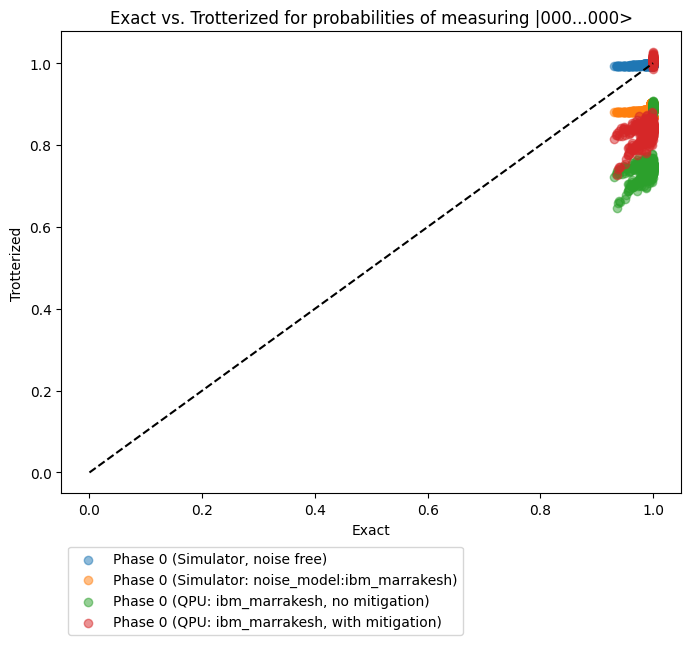

In [35]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim_noisy,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_nmit,
    label=f"Phase 0 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_mit,
    label=f"Phase 0 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

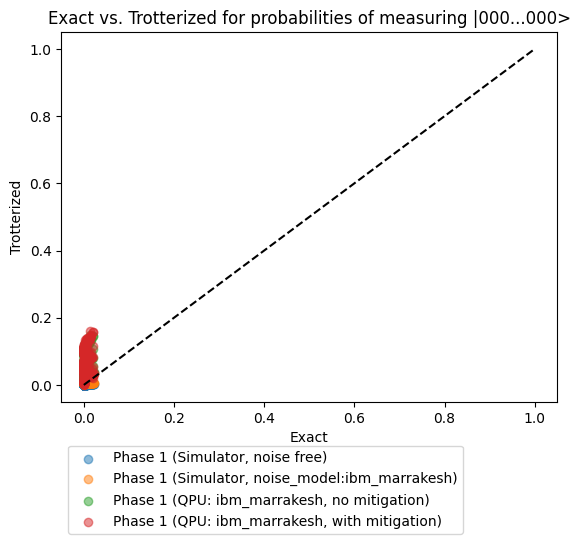

In [36]:
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim_noisy,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_nmit,
    label=f"Phase 1 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_mit,
    label=f"Phase 1 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

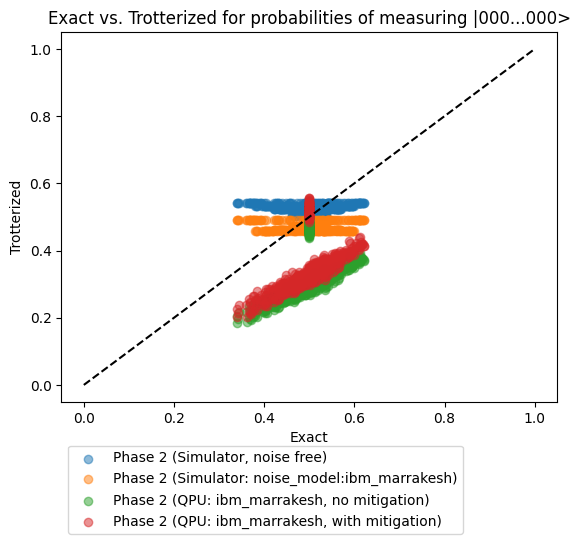

In [37]:
plt.scatter
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim_noisy,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_nmit,
    label=f"Phase 2 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_mit,
    label=f"Phase 2 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

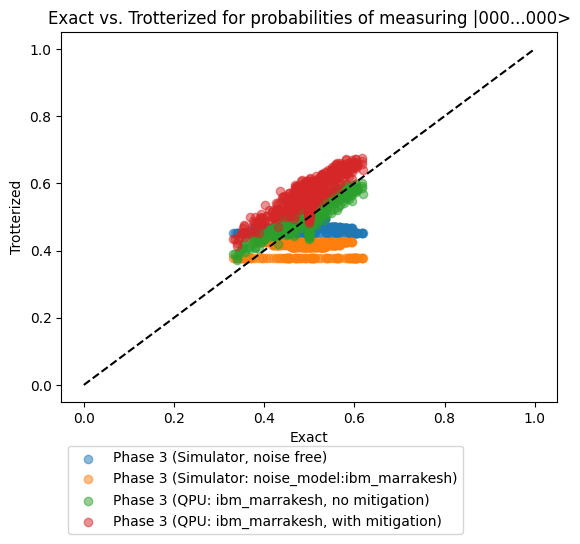

In [38]:
plt.scatter
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim_noisy,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_nmit,
    label=f"Phase 3 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_mit,
    label=f"Phase 3 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()